## Life history traits model  
Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

,Species,Stock,Stock_Year,Age,maturity,survivorship,fecundity (num female pups per year),notes,model type,source_mat,...,linf_cm,growth_coeff_k,lmax_cm,age_max_yrs,temp_pref,nursery,depth_min,depth_max,depth_ave,param_complete
0,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,0,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
1,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,1,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
2,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,2,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
3,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,3,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
4,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,4,0.016088,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0


In [5]:
# Add  offspring size and  litter size relative to length at maturity
# Within a single species many studies look at the relationship between litter size/offspring size and maternal body size. 
# But I want to look at differences between species.  
# Offspring size relative to maternal body size says something about how much energy the mother puts into offpsring, which should relate to a50 and perahps s.
#cdata['treatment'] = 1 + cdata.prosoc_left + 2*cdata.condition
data['relative_litter_size'] = data.litter_size/data.length_maturity_cm
data['relative_offspring_size'] = (data.offspring_size_mm/10)/data.length_maturity_cm

In [6]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete', 'relative_litter_size',
       'relative_offspring_size'],
      dtype='object')

In [7]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 39)

In [8]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

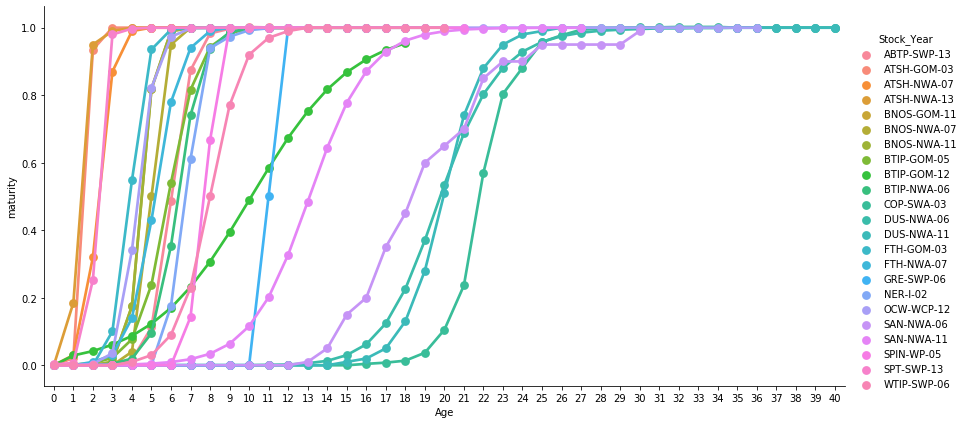

In [9]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [10]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [11]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [12]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]

In [13]:
LMAX

array([166. , 110. ,  81.3,  81.3, 130. , 130. , 130. , 191. , 191. ,
       191. , 275. , 329. , 329. , 150. , 150. , 190. , 133. , 285. ,
       204. , 204. , 300. , 131. , 160. ])

In [14]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
ROFFSZ = stdise(ROFFSZ)
LITT = stdise(LITT)
RLITT = stdise(RLITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
#need to transform habitat somehow?

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

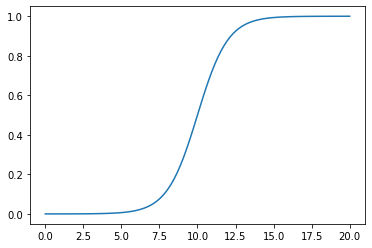

In [15]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

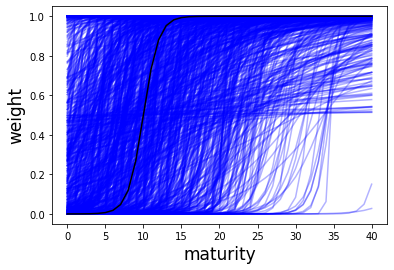

In [16]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('maturity', fontsize=17)
plt.ylabel('weight', fontsize=17);

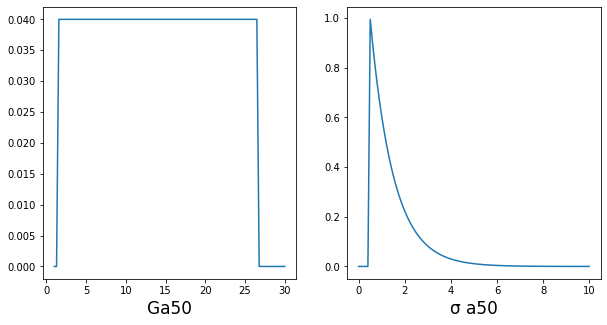

In [17]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

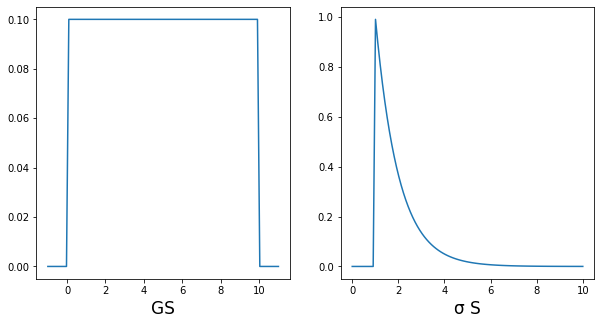

In [18]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [19]:
# random effects model (Aaron model)
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [20]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50x, a50_sigma, Ga50]


ValueError: Not enough samples to build a trace.

In [ ]:
for RV in mat1.basic_RVs:
    print(RV.name, RV.logp(mat1.test_point))

In [ ]:
#check model performance
#warnings.filterwarnings("Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used", 'once')
pm.traceplot(trace1);

In [ ]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

In [ ]:
# fixed effect model (Seb model)
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    #S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    #S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # now put all the priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [ ]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#check model performance
pm.traceplot(trace2);

In [ ]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

### Model Results

In [ ]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
# az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["mixed_effect", "fixed_effect"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('mat1&2_forest.jpg');

### Model Comparison

In [ ]:
#WAIC for model 1
pm.waic(trace1, scale='deviance')

In [ ]:
#WAIC for model 2
pm.waic(trace2, scale='deviance')

Model 1 WAIC = -3286  
Model 2 WAIC = 181  

Model 1 vastly preferred over model 2 as lower WAIC better than higher

#### Look for 'bad' datapoints

In [ ]:
loo1 = pm.loo(trace1, mat1)
loo1

In [ ]:
# show bad datapoints
mdata.iloc[loo1.pareto_k.values > 0.7]

In [ ]:
# Plot points with bad pareto k scores

badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

plt.figure(figsize=(15,10))
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s], s=70) for s in StockYr]
plt.scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=70)


In [ ]:
loo2 = pm.loo(trace2, mat2)
loo2

In [ ]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]
mdata.iloc[loo2.pareto_k.values > 0.7]

### Plot model fits

In [ ]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
colnames = np.array(list(result1.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result1.to_csv('mat1_model_results.csv')
result1.head()

In [ ]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)

# Edit column names
colnames = np.array(list(result2.columns), dtype=object)
colnames[np.array([list(colnames).index(x) for x in grep('mu_a50',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('mu_S',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

# take new names from text replacement commands and inserts them into df column names
result2.columns = list(colnames)

os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result2.to_csv('mat2_model_results.csv')
result2.head()

In [ ]:
# Grab data from mat1 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s
a50s = np.array([np.median(result1[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [ ]:
# Grab data from mat2 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
#μa50s2 = np.array([np.median(result2[x]) for x in np.array(['a50_'+str(s) for s in list(range(len(StockYr)))])]).T
a50s2 = np.array([np.median(result2[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
Ss2 = np.array([np.median(result2[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T
# Ss2 = np.median(result2.GS)

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [ ]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,5))
ax_ = axes.flatten()

#Plot mat1
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects model')

#Plot mat2
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss2,a50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects model')

#save results
plt.savefig('mat1_mat2_modelfit.jpg',dpi=300);

In [ ]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss,μa50s)]
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)

#save results
plt.savefig('mat1_modelfit.jpg',dpi=300);

In [ ]:
Ss2

In [ ]:
a50s

In [ ]:
#double check model 1 fit
def sigmoid(a):
    return(1/(1+np.exp(-1.67*(a-8))))
a = np.linspace(0,40,100)
plt.plot(a, sigmoid(a))

In [ ]:
# Look at relationship betweeen a50 and s
plt.scatter(Ss, μa50s)

b1,b0 = np.polyfit(Ss,μa50s, 1)
plt.plot(Ss,b0+b1*Ss,c='black')


plt.xlabel('S', fontsize=17)
plt.ylabel('a50', fontsize=17);